# Predicción del precio en Airbnb

## Model de regresión con Gradient Boosting

### Librerías

In [1]:
## IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Leemos dataframe de train limpio
airbnb = pd.read_csv('./train_clean.csv', sep=';', decimal='.')

### Entrenamiento de modelo Gradient Boosting Regressor

Entrenamos el modelo Gradient Boosting con la selección de características realizada en el notebook "PracticaML-Sofia-Seleccion_variables.ipynb"

In [3]:
# Selección de 18 características
sel_var = ['Room Type', 'Accommodates', 'Cleaning Fee', 'Has AC',
       'Guests Included', 'Bathrooms', 'Security Deposit', 'Latitude',
       'Host Listings Count', 'Longitude', 'Minimum Nights', 'Extra People',
       'Availability 365', 'Days Since Last Review', 'Days As Host',
       'Neigh_Centro', 'Review Scores Rating', 'Number of Reviews']


In [4]:
new_list_cols = sel_var
airbnb_data = airbnb[['Price'] + new_list_cols]

data = airbnb_data.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = airbnb_data.columns[1:]

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

Niterations = [500,1000,2000,4000]
learningRate = [0.1,0.05, 0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.684
best parameters: {'learning_rate': 0.1, 'n_estimators': 500}


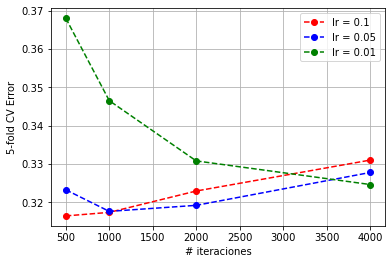

In [6]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
#plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

In [14]:
print("Train: ",bt.score(X_train,y_train))

Train:  0.854940456224056


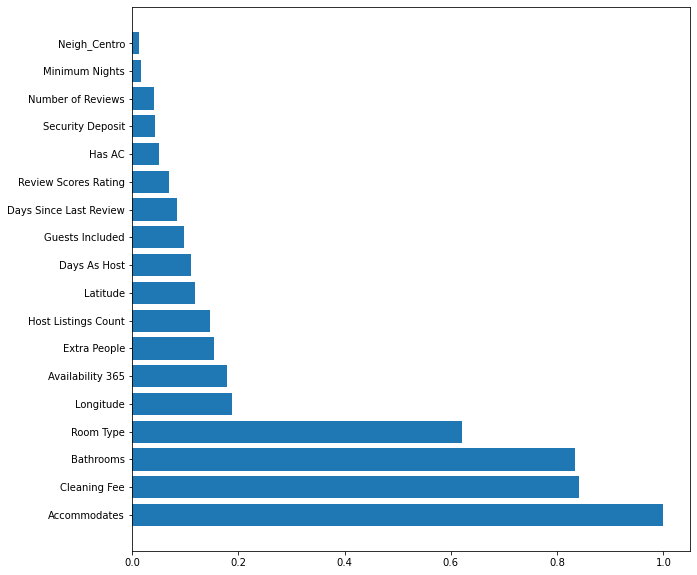

In [8]:
# Vemos también el resultado de la importancia de las variables que devuelve este modelo
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

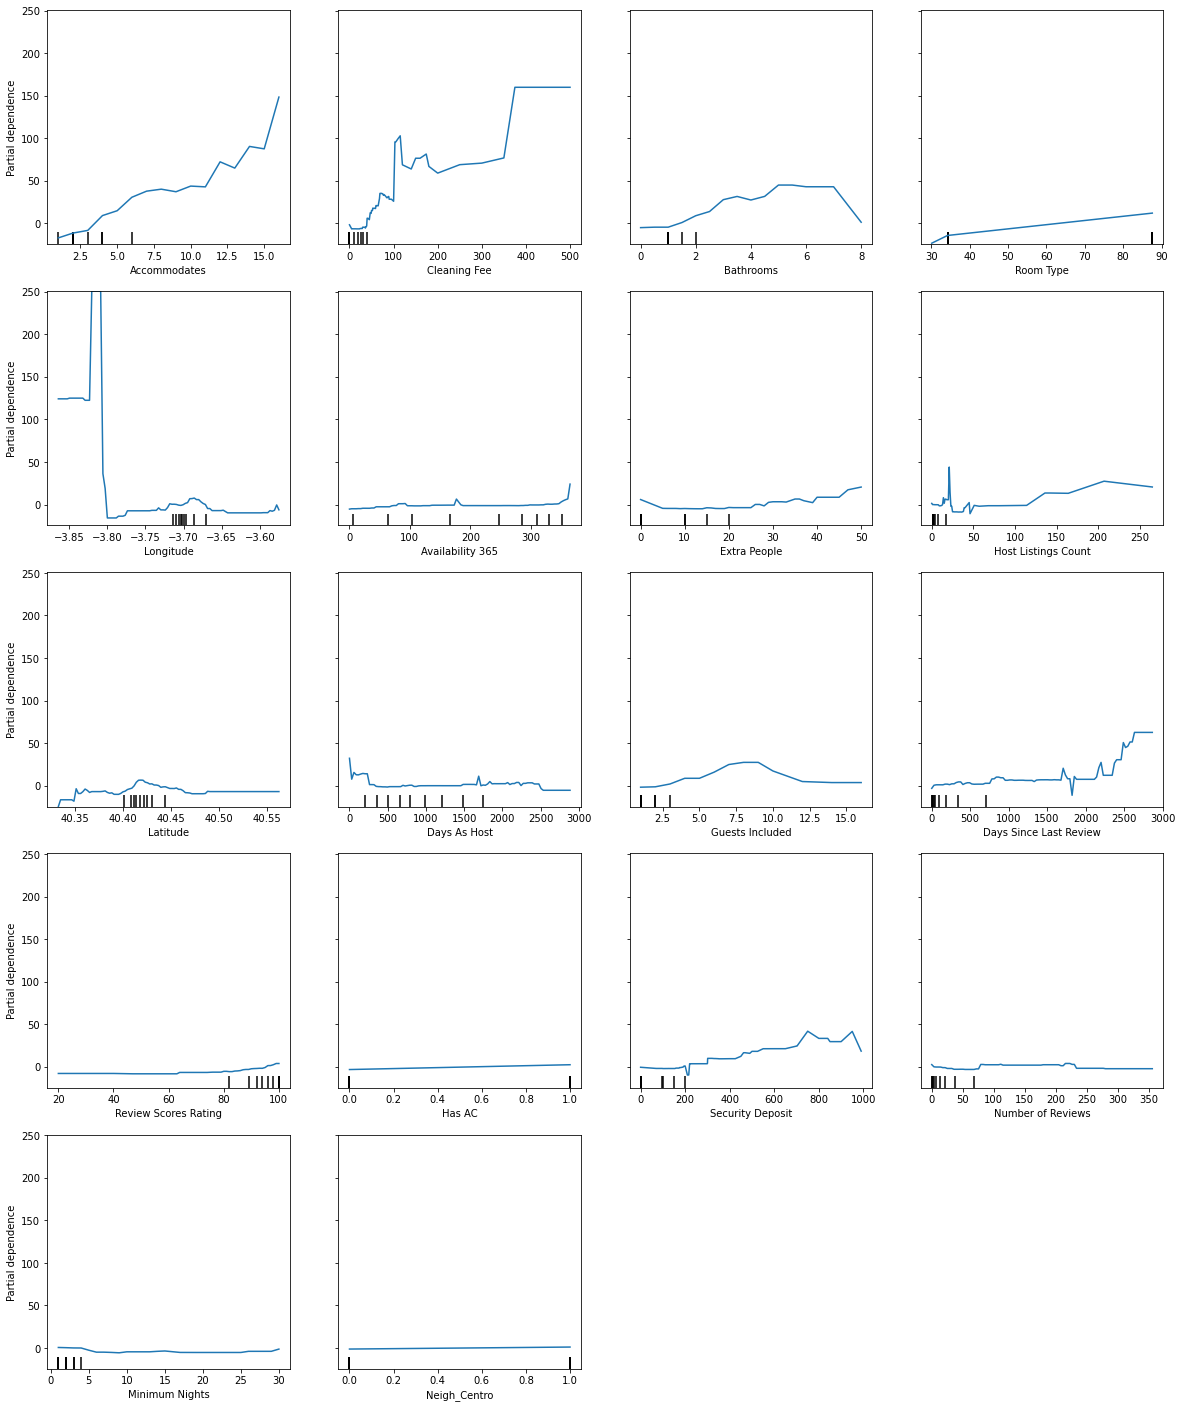

In [9]:
# Representamos la dependencia de cada característica con la variable target
from sklearn.inspection import plot_partial_dependence

importances = bt.feature_importances_
importances = importances / np.max(importances)
indices = np.argsort(importances)[::-1]

plot_partial_dependence(bt, X_train, indices, feature_names=feature_names, percentiles=(0.0, 1.0), n_cols = 4)
fig = plt.gcf()
fig.set_size_inches(20,25)
plt.show()

Algunas deducciones para la interpretabilidad del modelo:

"Accomodates" tiene una tendencia prácticamente creciente con el precio

"Bathrooms" también tiene una tendencia más o menos creciente hasta un valor de 7 y después cae.

"Cleaning Fee" y "Longitude" tienen una dependencia muy variable

### Validación del conjunto de test

In [10]:
# Leemos el conjunto de test previamente limpiado y preprocesado
test = pd.read_csv('./test_clean.csv', sep=';', decimal='.')

In [11]:
# convertimos el DataFrame al formato necesario para scikit-learn
#lista_cols_test = test.columns.tolist()
#lista_cols_test.remove('Price')
test_data = test[['Price'] + new_list_cols]

#### Validación del modelo Gradient Boosting

In [12]:
test_data = test[['Price'] + new_list_cols]

test_val = test_data.values

y_test = test_val[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = test_val[:,1:]      # nos quedamos con el resto

feature_names = test_data.columns[1:]

In [13]:
print("Test: ",bt.score(X_test,y_test))

Test:  0.6628985957562512


Evaluación del modelo con 18 variables (métrica score R2)

 - Train:  0.854940456224056
 - Test:  0.6628985957562512

Este modelo tiene unas prestaciones ligeramente mejores al Random Forest pero sigue presentando overfitting y por tanto sigue sin ser capaz de generalizar.

A falta del estudio más detallado de otros modelos de regresión, la conclusión principal de esta práctica es que se necesita un mejor conocimiento del dominio para generar más variables de interés para la predicción del precio. 